
##**Predicting DNA N6-Methyladenine Sites in Rice Genome**

#**Training for the first dataset named rice_lv dataset.**

---

In [ ]:
import numpy as np

import matplotlib as mpl
mpl.use('Agg')

from keras.models import Model
from keras.layers import Dense, Dropout, Conv1D, Input,MaxPooling1D,Flatten,LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD,Adam
import random
import pandas as pd 
import numpy as np
from keras import regularizers
from keras.metrics import binary_accuracy
from sklearn.metrics import confusion_matrix,recall_score,matthews_corrcoef,roc_curve,roc_auc_score,auc
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import os, sys, copy, getopt, re, argparse
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from keras import losses
import pickle

from scipy import interp

from sklearn.model_selection import train_test_split
import tensorflow as tf



In [ ]:
with open('/content/data/rice_Lv/rice_Lv_neg') as f:
  data = f.readlines()

In [ ]:
data_tuple =[(d.split(',')[0], d.split(',')[-1].strip()) for d in data]

xx = [val[0] for val in data_tuple]
yy = [val[1] for val in data_tuple]

In [ ]:
with open('/content/data/rice_Lv/rice_Lv_pos') as f:
  data1 = f.readlines()

data_tuple1 =[(d.split(',')[0], d.split(',')[-1].strip()) for d in data1]

In [ ]:
xx1 = [val[0] for val in data_tuple1]
yy1 = [val[1] for val in data_tuple1]


In [ ]:
x = xx1[1:]+xx[1:]
y = yy1[1:] + yy[1:]

In [ ]:
#Shuffling the data
for i in range(len(y)-1, 0, -1):
     
    # Pick a random index from 0 to i
    j = random.randint(0, i + 1)
   
    # Swap arr[i] with the element at random index
    y[i], y[j] = y[j], y[i]

In [ ]:
#Shuffling the data
for i in range(len(x)-1, 0, -1):
     
    # Pick a random index from 0 to i
    j = random.randint(0, i + 1)
   
    # Swap arr[i] with the element at random index
    x[i], x[j] = x[j], x[i]

In [ ]:
# creating one hot encoded values for each class in y
classes = list(set(y))
encoded_y = tf.one_hot(range(len(classes)), depth=len(classes))

# creating one hot encoded values for each symbol in x
primary_symbols = ['A', 'G', 'C', 'T']
derived_symbols = ['D', 'S', 'R', 'N']
symbols = primary_symbols + derived_symbols

## symbol representing equal probability of primary symbols occurence
symbol_occ_map = {
    'D': ['A', 'G', 'T'],
    'S': ['C', 'G'],
    'R': ['A', 'G'],
    'N': ['A', 'G', 'C', 'T']
}

encoded_sym = tf.one_hot(range(len(primary_symbols)), depth=len(primary_symbols))

symbol_map = {sym:encoded_sym[idx] for idx, sym in enumerate(primary_symbols)}

for sym in derived_symbols:
  symbol_map[sym] = np.sum([symbol_map[p_sym] for p_sym in symbol_occ_map[sym]], axis=0)

for sym in symbols:
    print(f"{sym} -> {symbol_map[sym]}")

# mapping class/symbol names to their hot encoded values
class_map = {class_:encoded_y[idx] for idx, class_ in enumerate(classes)}


print(f"symbols: {symbols}")
print(f"Encoded symbol: {encoded_sym}")

print(f"classes: {classes}")
#print(f"Encoded classes: {encoded_y}")


A -> [1. 0. 0. 0.]
G -> [0. 1. 0. 0.]
C -> [0. 0. 1. 0.]
T -> [0. 0. 0. 1.]
D -> [1. 1. 0. 1.]
S -> [0. 1. 1. 0.]
R -> [1. 1. 0. 0.]
N -> [1. 1. 1. 1.]
symbols: ['A', 'G', 'C', 'T', 'D', 'S', 'R', 'N']
Encoded symbol: [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
classes: ['0', '1']


In [ ]:
# to get symbol representation of sequence from one hot encoded values
to_symbol = lambda hot_encoded: "".join([symbols[idx] for idx in tf.argmax(hot_encoded, axis=1)])


def test_same(sample_val):
  sample_val = x[1293]
  sample_encoded = [symbol_map[char] for char in sample_val]
  reversed = to_symbol(sample_encoded)
  return sample_val == reversed

In [ ]:
X = np.array([[symbol_map[char] for char in sequence] for sequence in x])
Y = np.array([class_map[class_] for class_ in y])
print(f"X : {X.shape}")
print(f"Y : {Y.shape}")

X : (308000, 41, 4)
Y : (308000, 2)


In [ ]:
Y=Y[:, 0:1]

In [ ]:
# splitting data into train, test
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state=21)
print(f"Train X : {train_x.shape}")
print(f"Test X : {test_x.shape}")
print(f"Train Y : {train_y.shape}")
print(f"Test Y : {test_y.shape}")


Train X : (215600, 41, 4)
Test X : (92400, 41, 4)
Train Y : (215600, 1)
Test Y : (92400, 1)


In [ ]:
def getMode():

    input_shape = (41,4)

    inputs = Input(shape = input_shape)

    convLayer = Conv1D(filters = 16, kernel_size = 4,activation = 'relu',input_shape = input_shape, kernel_regularizer = regularizers.l2(1e-4), bias_regularizer = regularizers.l2(1e-4))(inputs);
    normalizationLayer = tfa.layers.GroupNormalization(groups = 4,axis=-1)(convLayer)
    #normalizationLayer = BatchNormalization()(convLayer);
    poolingLayer = MaxPooling1D(pool_size = 4)(normalizationLayer)
    flattenLayer = Flatten()(poolingLayer)

    dropoutLayer = Dropout(0.25)(flattenLayer)
    denseLayer = Dense(32, activation = 'elu',kernel_regularizer = regularizers.l2(1e-4),bias_regularizer = regularizers.l2(1e-4))(dropoutLayer)
    outLayer = Dense(1, activation='sigmoid')(denseLayer)

    model = Model(inputs = inputs, outputs = outLayer)
    model.compile(loss='binary_crossentropy', optimizer= SGD(momentum =0.95, lr = 0.05), metrics=[binary_accuracy]);

    print(model.summary())

    return model;

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 679 kB 32.3 MB/s 
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
import tensorflow_addons as tfa

In [ ]:
model = getMode()

In [ ]:
history = model.fit(train_x, train_y, batch_size = 32, epochs = 40, validation_data = (test_x, test_y))

Epoch 1/40
6738/6738 [==============================] - 22s 3ms/step - loss: 0.7521 - binary_accuracy: 0.5014 - val_loss: 0.7235 - val_binary_accuracy: 0.5013
Epoch 2/40
6738/6738 [==============================] - 23s 3ms/step - loss: 0.7552 - binary_accuracy: 0.5016 - val_loss: 0.7221 - val_binary_accuracy: 0.5013
Epoch 3/40
6738/6738 [==============================] - 21s 3ms/step - loss: 0.7523 - binary_accuracy: 0.4979 - val_loss: 0.7015 - val_binary_accuracy: 0.5008
Epoch 4/40
6738/6738 [==============================] - 22s 3ms/step - loss: 0.7550 - binary_accuracy: 0.4993 - val_loss: 0.7094 - val_binary_accuracy: 0.4987
Epoch 5/40
6738/6738 [==============================] - 21s 3ms/step - loss: 0.7542 - binary_accuracy: 0.5010 - val_loss: 0.7093 - val_binary_accuracy: 0.5014
Epoch 6/40
6738/6738 [==============================] - 23s 3ms/step - loss: 0.7431 - binary_accuracy: 0.5019 - val_loss: 0.7262 - val_binary_accuracy: 0.4987
Epoch 7/40
6738/6738 [========================

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def plot(args, labels, x_label: str = None, y_label: str = None, tag: str = None, path: str = '.', show=True):
    for arg, label in zip(args, labels):
        epochs = [i+1 for i in range(len(arg))]
        plt.plot(epochs, arg, label=label)

    if y_label:
        plt.ylabel(y_label)
    if x_label:
        plt.xlabel(x_label)

    if tag:
        plt.title(tag)

    plt.legend()
    if path:
        plt.savefig(path)
    if show:
      plt.show()

In [ ]:
print(history.history.keys())
data = history.history

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Final Train Acc = 0.5014563798904419
Final Test Acc = 0.5012770295143127


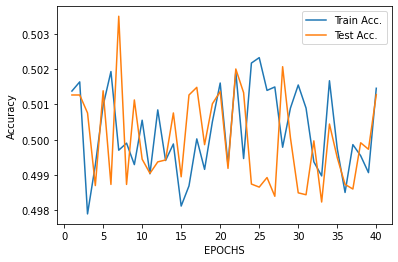

In [ ]:
print(f"Final Train Acc = {data['binary_accuracy'][-1]}")
print(f"Final Test Acc = {data['val_binary_accuracy'][-1]}")
plot([data['binary_accuracy'], data['val_binary_accuracy']], ['Train Acc.', 'Test Acc.'], x_label='EPOCHS', y_label='Accuracy')

Final Train Loss = 0.7240574359893799
Final Test Loss = 0.7210254073143005


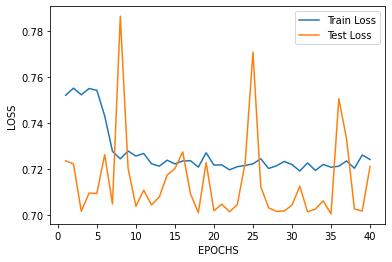

In [ ]:
print(f"Final Train Loss = {data['loss'][-1]}")
print(f"Final Test Loss = {data['val_loss'][-1]}")
plot([data['loss'], data['val_loss']], ['Train Loss', 'Test Loss'], x_label='EPOCHS', y_label='LOSS')

In [ ]:
from keras.layers import  Input, Embedding, Dense, LSTM
from keras.models import Model
import keras
import keras.utils

In [ ]:
model_n = keras.models.Sequential()

model_n.add(keras.layers.LSTM(units=32, batch_input_shape=(16, 41, 4), return_sequences=True))
model_n.add(keras.layers.LSTM(units=64, return_sequences=False))
model_n.add(Dense(units=1, activation='sigmoid'))
model_n.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (16, 41, 32)              4736      
_________________________________________________________________
lstm_3 (LSTM)                (16, 64)                  24832     
_________________________________________________________________
dense_3 (Dense)              (16, 1)                   65        
Total params: 29,633
Trainable params: 29,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_n.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
hist_ = model_n.fit(train_x, train_y,
          batch_size=16, epochs=10,
          validation_data=(test_x, test_y))

Epoch 1/10
13475/13475 [==============================] - 336s 25ms/step - loss: 0.6936 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5013
Epoch 2/10
13475/13475 [==============================] - 331s 25ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6936 - val_accuracy: 0.4987
Epoch 3/10
13475/13475 [==============================] - 331s 25ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 4/10
13475/13475 [==============================] - 329s 24ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 5/10
13475/13475 [==============================] - 332s 25ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 6/10
13475/13475 [==============================] - 330s 24ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4974
Epoch 7/10
13475/13475 [==============================] - 332s 25ms/step - loss: 0.6932 - accuracy: 0.5030

In [ ]:
print(hist_.history.keys())
data_n = hist_.history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Final Train Acc = 0.5039888620376587
Final Test Acc = 0.4972619116306305


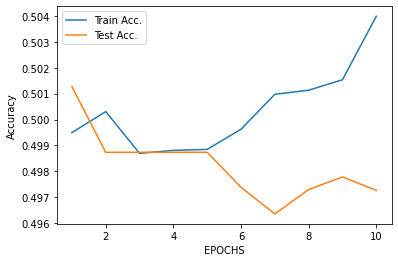

In [ ]:
print(f"Final Train Acc = {data_n['accuracy'][-1]}")
print(f"Final Test Acc = {data_n['val_accuracy'][-1]}")
plot([data_n['accuracy'], data_n['val_accuracy']], ['Train Acc.', 'Test Acc.'], x_label='EPOCHS', y_label='Accuracy')

Final Train Loss = 0.7240574359893799
Final Test Loss = 0.7210254073143005


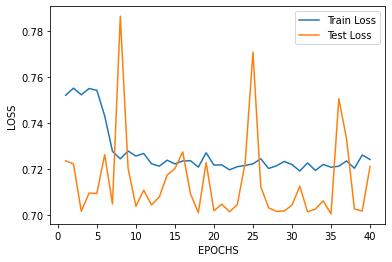

In [ ]:
print(f"Final Train Loss = {data['loss'][-1]}")
print(f"Final Test Loss = {data['val_loss'][-1]}")
plot([data['loss'], data['val_loss']], ['Train Loss', 'Test Loss'], x_label='EPOCHS', y_label='LOSS')